In [141]:
########################################################
#  Create Date:         4/15/2025
#  Design Name:         mallBasketAnalysis
#  Project:             Clustering
#  Description:         Ever wonder who's splurging at the mall and who is just window shopping? This project takes a pile of numbers and turns them into shopper personalities, no spreadsheets harmed in the process. Clustering makes the data easier to digest (think  pie charts, not dry toast), setting up the kind of insights marketers dream about. Data meets drama, mall-style.
#
#  Additional Comments:
#  adapted from Jana Hatem's Kaggle Kernel
#  https://www.kaggle.com/code/jeeelsheikh/clustering-analysis-on-mall-customers?select=Mall_Customers.csv
#
########################################################


In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

### Load the dataset

In [143]:
data = pd.read_csv('data/Mall_Customers.xls')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [145]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### Scatter Pairplot
Histograms are a common way to visualize data distributions, but they can be affected by the choice of bins. KDE plots provide a smoother, continuous representation of the data distribution, potentially revealing more subtle patterns

How KDE Works:
KDE works by placing a "kernel" (like a Gaussian distribution) at each data point. Then, it sums up these kernels, creating a continuous curve that represents the estimated probability density.

Benefits of KDE:
- Provides a continuous representation of the data distribution.
- Can be more helpful for understanding data distributions compared to histograms, especially when the number of data points is limited.
- Can be used to identify outliers in the data by examining regions of low probability density.


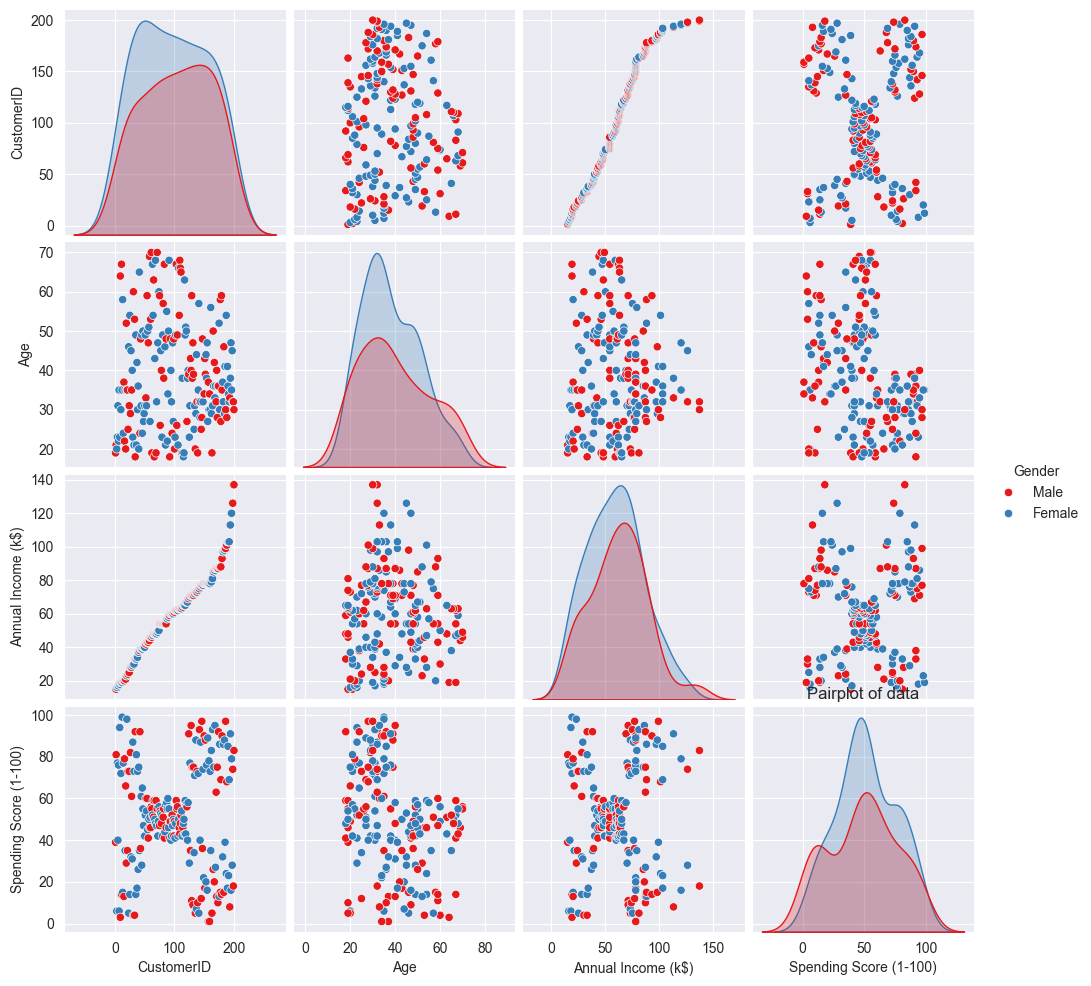

In [146]:
# seaborn's scatter pairplot offers more customization (different diagonal plots, (histogram, kde), color points by categorical  variable and more control of appearance over pandas scatter pairplot

# pairplot data male vs female8464
# diag_kind: kernel density estimation
sns.pairplot(data, hue='Gender', kind='scatter', diag_kind='kde', palette='Set1')
plt.title('Pairplot of data')
plt.show()

Select Relevant columns
consider dependencies, covariance and correlations
sometimes might have to do log transformations of skewed data to get normal bell-curve of target (Normal distribution on dependent variable provides more reliable results)

### VIF analysis

In [147]:
# need to one-hot-encode gender
data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})
data_vif = data.drop(columns =['CustomerID'])

data_vif.head()
# compute
df_vif = pd.DataFrame({"Variable": data_vif.columns,
                       "VIF": [vif(data_vif.values, i) for i in range(data_vif.shape[1])]
})

print("current VIF:\n")
for index, row in df_vif.iterrows():
    print(f"Variable: {row['Variable']}, VIF: {row['VIF']:.2f}")

current VIF:

Variable: Gender, VIF: 1.76
Variable: Age, VIF: 4.46
Variable: Annual Income (k$), VIF: 4.98
Variable: Spending Score (1-100), VIF: 3.30


### Normalize the data for better clustering performance

Text(0, 0.5, "Cluster 'Euclidian' distance")

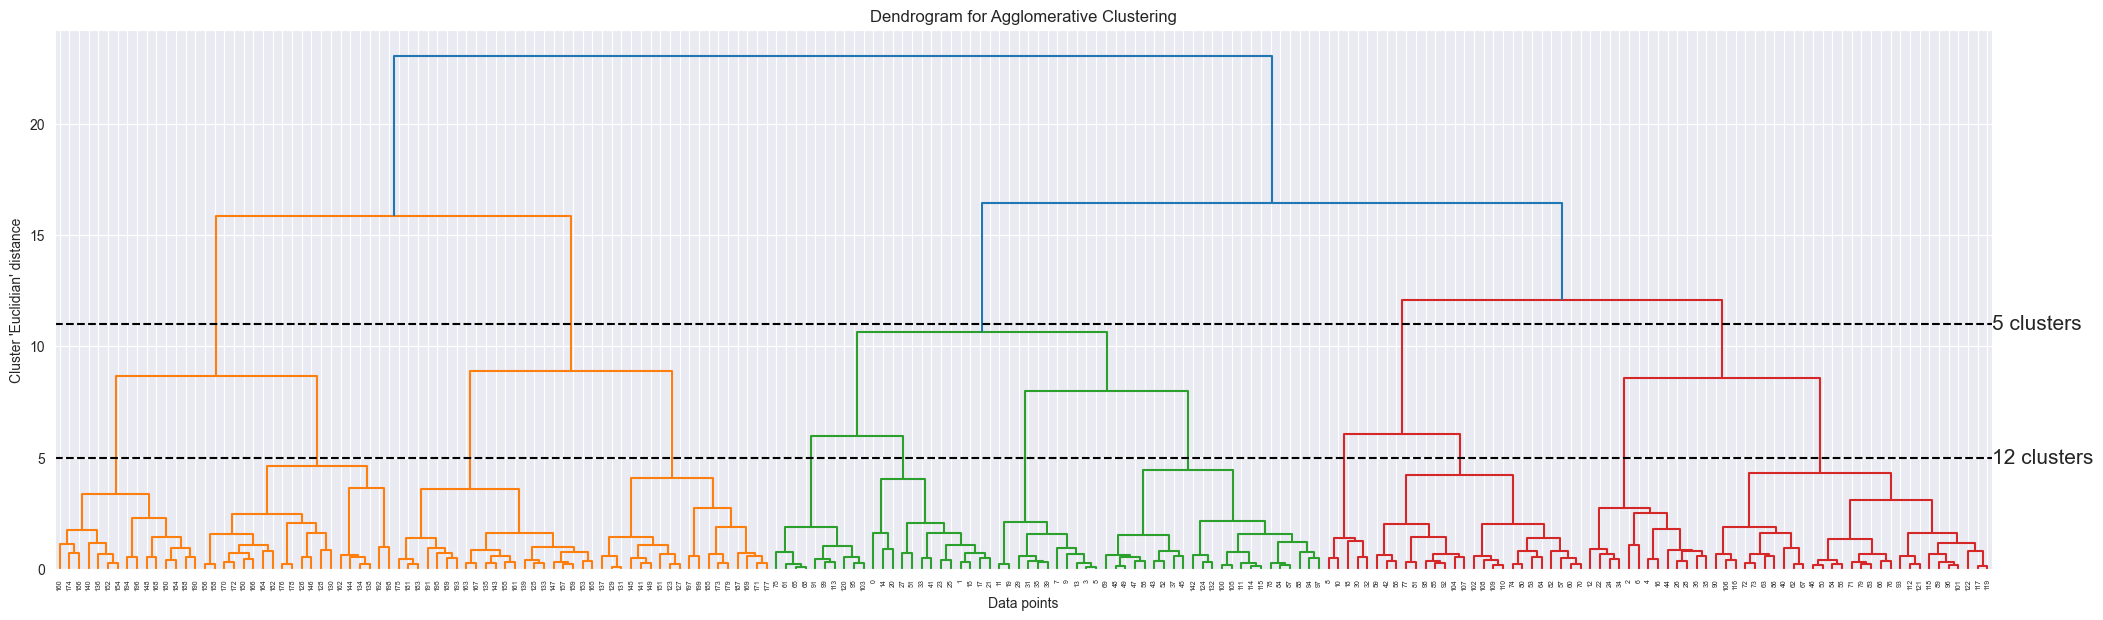

In [148]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# Determine optimal # of clusters
plt.figure(figsize=(25, 7))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method="ward"))

# get axis bounds
ax = plt.gca()
bounds = ax.get_xbound()

# add cluster cut line and text
ax.plot(bounds, [11, 11], '--', c='k')
ax.text(bounds[1], 11, '5 clusters', va='center', fontdict={'size':15})

ax.plot(bounds, [5, 5], '--', c='k')
ax.text(bounds[1], 5, '12 clusters', va='center', fontdict={'size':15})

plt.title("Dendrogram for Agglomerative Clustering")
plt.xlabel("Data points")
plt.ylabel("Cluster 'Euclidian' distance")

### Agglomerative Clustering

In [149]:
agglom = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
y_agglo = agglom.fit_predict(X_scaled)
data.loc[:, 'Labels'] = y_agglo

# plot
fig = px.scatter(data, x='Annual Income (k$)',
                 y='Spending Score (1-100)',
                 color=data['Labels'].astype(str),
                 title='Agglomerative Clustering w/ 5 clusters',
                 labels={'Labels': 'Cluster'},
                 color_discrete_sequence=px.colors.qualitative.Set1)
iplot(fig)

### K-means clustering
find the optimal number of clusters w/ Elbow method

In [150]:
# Within-Cluster Sum of Squares
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    y_kmeans = kmeans.fit_predict(data[['Annual Income (k$)', 'Spending Score (1-100)']])
    data['KMeans_Labels'] = y_kmeans
print(wcss)

[999.9999999999999, 715.2750473761118, 573.8386868500047, 458.1834192867399, 389.4085104827474, 339.74481467362034, 294.74687318598563, 254.41521729352556, 222.6736552828426, 190.34252178715482]


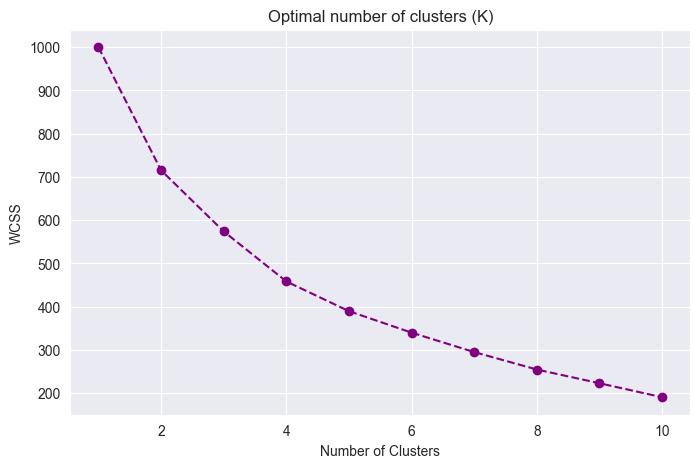

In [151]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='purple')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Optimal number of clusters (K)')
plt.show()

### DBSCAN Clustering

In [152]:
db = DBSCAN(eps=15, min_samples=6)
y = db.fit_predict(data[['Annual Income (k$)', 'Spending Score (1-100)']])
data['Labels'] = y

In [153]:
#plot
fig = px.scatter(data,
                x='Annual Income (k$)',
                y='Spending Score (1-100)',
                color=data['Labels'].astype(str),
                title='DBSCAN Clustering (eps=15, min_samples=6)',
                labels={'Labels': 'Cluster'}, color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_layout(
    xaxis_title="Annual Income (k$)",
    yaxis_title="Spending Score (1-100)",
    title='DBSCAN Clustering (eps=15, min_samples=6)'
)

iplot(fig)

### Evaluate Silhouette Scores
(compactness of a cluster) where a higher number is better

In [154]:
kmeans_silhouette = silhouette_score(data[['Annual Income (k$)', 'Spending Score (1-100)']], y_kmeans)
agglomerative_silhouette = silhouette_score(data[['Annual Income (k$)', 'Spending Score (1-100)']], data['Labels'])
dbscan_silhouette = silhouette_score(data[['Annual Income (k$)', 'Spending Score (1-100)']], data['Labels'])

print("\nSilhouette Scores:")
print(f"K-Means: {kmeans_silhouette:.3f}")
print(f"Agglomerative: {agglomerative_silhouette:.3f}")
print(f"DBSCAN: {dbscan_silhouette:.3f}")


Silhouette Scores:
K-Means: 0.441
Agglomerative: 0.417
DBSCAN: 0.417


### Evaluate w/ Ground Truth

In [155]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Ground truth labels (if available)
true_labels = data['True_Labels']  # Replace with actual ground truth column

# Evaluate Adjusted Rand Index (ARI)
kmeans_ari = adjusted_rand_score(true_labels, data['KMeans_Labels'])
agglomerative_ari = adjusted_rand_score(true_labels, data['Labels'])  # Agglomerative
dbscan_ari = adjusted_rand_score(true_labels, data['Labels'])  # DBSCAN

print("Adjusted Rand Index (ARI):")
print(f"K-Means: {kmeans_ari:.2f}")
print(f"Agglomerative: {agglomerative_ari:.2f}")
print(f"DBSCAN: {dbscan_ari:.2f}")

KeyError: 'True_Labels'

# Evaluate w/ Ground Truth
clustering labels are usually not available to compare results to ground truth. ARI and NMI will typically only help in developing algorithms, not evaluating the models success


In [ ]:
# Ground truth labels (if available)
true_labels = data['True_Labels']  # Replace with actual ground truth column

# Evaluate Adjusted Rand Index (ARI)
kmeans_ari = adjusted_rand_score(true_labels, data['KMeans_Labels'])
agglomerative_ari = adjusted_rand_score(true_labels, data['Labels'])  # Agglomerative
dbscan_ari = adjusted_rand_score(true_labels, data['Labels'])  # DBSCAN

print("Adjusted Rand Index (ARI):")
print(f"K-Means: {kmeans_ari:.2f}")
print(f"Agglomerative: {agglomerative_ari:.2f}")
print(f"DBSCAN: {dbscan_ari:.2f}")